## A. 라벨정보 포함한 이미지 데이터셋 만들기

### 1.필요한 라이브러리 임포트

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

!unzip cats_and_dogs_filtered.zip

In [2]:
import os
from glob import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
!pwd
!ls /content/cats_and_dogs_filtered/train
!ls /content/cats_and_dogs_filtered/validation

/content
cats  dogs
cats  dogs


## E. MobileNet Transfer Learning & Fine-tuning 모델링

### 1. Build Model

In [6]:
# 하이터 파라미터 정의
input_shape = (224, 224, 3)
num_classes = 2

In [11]:
# 이미지 패스 지정
img_path ='/content/cats_and_dogs_filtered'
train_dir = os.path.join(img_path, 'train')
validation_dir = os.path.join(img_path, 'validation')

In [58]:
# image_dataset_from_directory 함수 활용하여
# 이미지 폴더 밑의 이미지들에 대해 원핫인코딩된 labeling수행, 이미지 배치, 셔플 수행

batch_size = 32
image_size=(224, 224)

# Train Dataset 만들기
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory=train_dir,
                                             label_mode="binary",   # binary , categorical
                                             batch_size=batch_size,
                                             image_size=image_size,      # 사이즈 확인
                                             seed=42,
                                             shuffle=True,
                                             #validation_split=0.2,
                                             #subset="training"    # One of "training" or "validation". Only used if validation_split is set.
                                            )

# Test Dataset 만들기
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory=validation_dir,
                                             label_mode="binary",   # binary , categorical
                                             batch_size=batch_size,
                                             image_size=image_size,      # 사이즈 확인
                                             seed=42,
                                             #validation_split=0.2,
                                             #subset="validation"    # One of "training" or "validation". Only used if validation_split is set.
                                            )

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


<ipython-input-59-55ac11ee1e22>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_idx = int(labels[i].numpy())


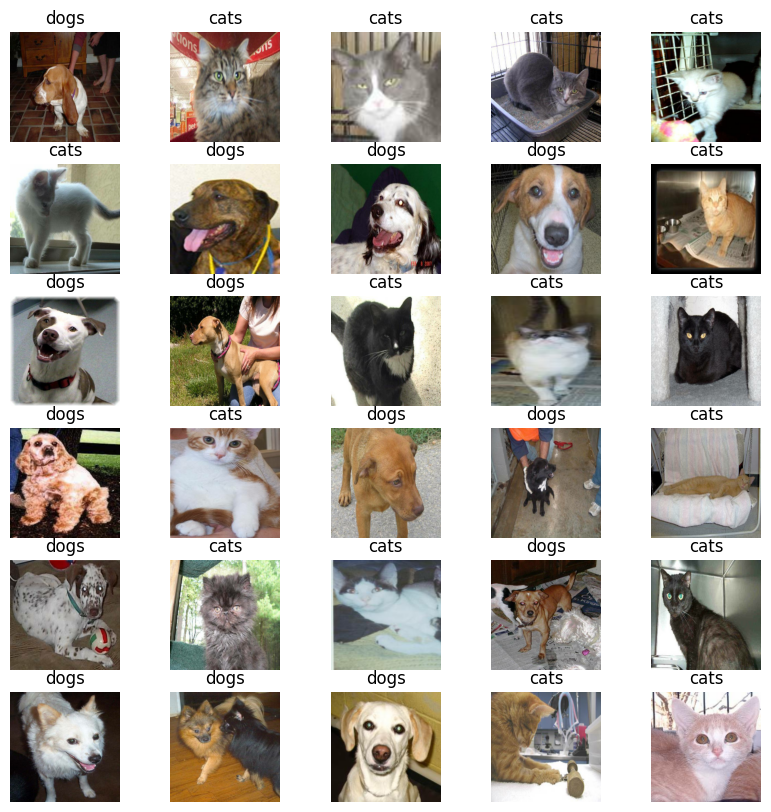

In [59]:
plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
    for i in range(30):
        ax = plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # float를 int로 변환
        label_idx = int(labels[i].numpy())
        plt.title(class_names[label_idx])
        plt.axis("off")

In [60]:
# 사전 훈련된 모델 MobileNetV2에서 기본 모델을 생성합니다.
# 아래와 같은 형식을 MobileNetV2 Transfer Learning 사용하며 됩니다.

base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)

In [ ]:
# tf.keras.applications.MobileNetV2 모델은 [-1, 1]의 픽셀 값을 예상하지만 이 시점에서 이미지의 픽셀 값은 [0, 255]입니다.
# MobileNetV2 모델에서 제대로 수행하기 위해 크기를 [-1, 1]로 재조정해야 합니다.(안하고 수행해도 성능 잘 나옴)
# 방법 2가지 있음
# 첫번째 방법 : preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# 두번째 방법 : rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [61]:
# MobileNet V2 베이스 모델 고정하기
base_model.trainable = False

In [67]:
# 모델 구축 : 이미지 픽셀값 조정 수행하기(Rescaling) --> 성능 더 잘 나옴.

inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # 3차원(7, 7, 1280) --> 1차원(1280)으로 줄이기 : GlobalAveragePooling2D
#이미지 갯수 5개
#output = tf.keras.layers.Dense(5, activation='softmax')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_6 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [71]:
# 모델 compile
learning_rate = 0.0003
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              #loss='categorical_crossentropy',  # Loss Function
              loss='binary_crossentropy',  # Loss Function
              metrics=['accuracy'])             # Metrics / Accuracy

### 2. Callback

In [72]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# ModelCheckpoint
checkpoint_path = "my_checkpoint.keras"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

### 3. 모델 학습

In [73]:
# image_dataset_from_directory 이용하여 DataSet을 만들었으며
# num_epochs = 10
# batch_size = 32

history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs=10,
    callbacks=[es, checkpoint]
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5047 - loss: 2.6616
Epoch 1: val_loss improved from inf to 0.66782, saving model to my_checkpoint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 179ms/step - accuracy: 0.5049 - loss: 2.6494 - val_accuracy: 0.6150 - val_loss: 0.6678
Epoch 2/10
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7656 - loss: 0.5147
Epoch 2: val_loss improved from 0.66782 to 0.28833, saving model to my_checkpoint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.7678 - loss: 0.5121 - val_accuracy: 0.9360 - val_loss: 0.2883
Epoch 3/10
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9485 - loss: 0.2532
Epoch 3: val_loss improved from 0.28833 to 0.18150, saving model to my_checkpoint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9487 - loss: 0.2524 - val_accuracy: 0.9720 - val_loss: 0.1815
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9716 - loss: 0.1676
Epoch 4: val_loss improved from 0.18150 to 0.1343

### 4. 성능 그래프

In [74]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

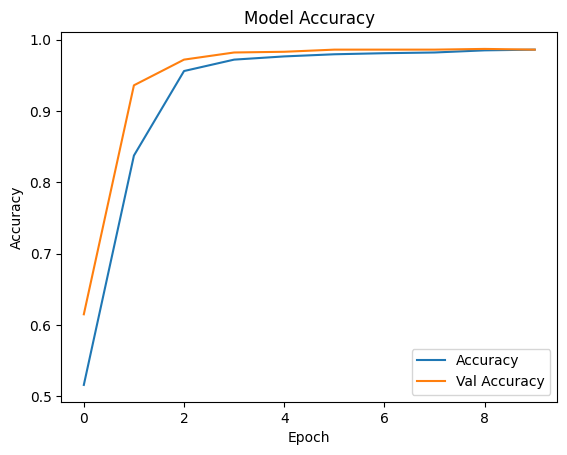

In [75]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

### 5. Predict

In [76]:
# test_generator 샘플 데이터 가져오기
# 배치 사이즈 32 확인

batch_img, batch_label = next(iter(test_ds))
print(batch_img.shape)
print(batch_label.shape)

(32, 224, 224, 3)
(32, 1)


In [77]:
# 이미지 rescale 되어 있는 상태
batch_img[0][0][:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[205.     , 201.     , 189.     ],
       [204.69643, 200.69643, 188.69643],
       [204.16072, 200.16072, 188.16072],
       [204.     , 200.     , 188.     ],
       [204.     , 200.     , 188.     ],
       [203.55357, 199.55357, 187.55357],
       [203.01785, 199.01785, 187.01785],
       [203.     , 199.     , 187.     ],
       [203.05357, 199.05357, 187.05357],
       [203.58928, 199.58928, 187.58928]], dtype=float32)>

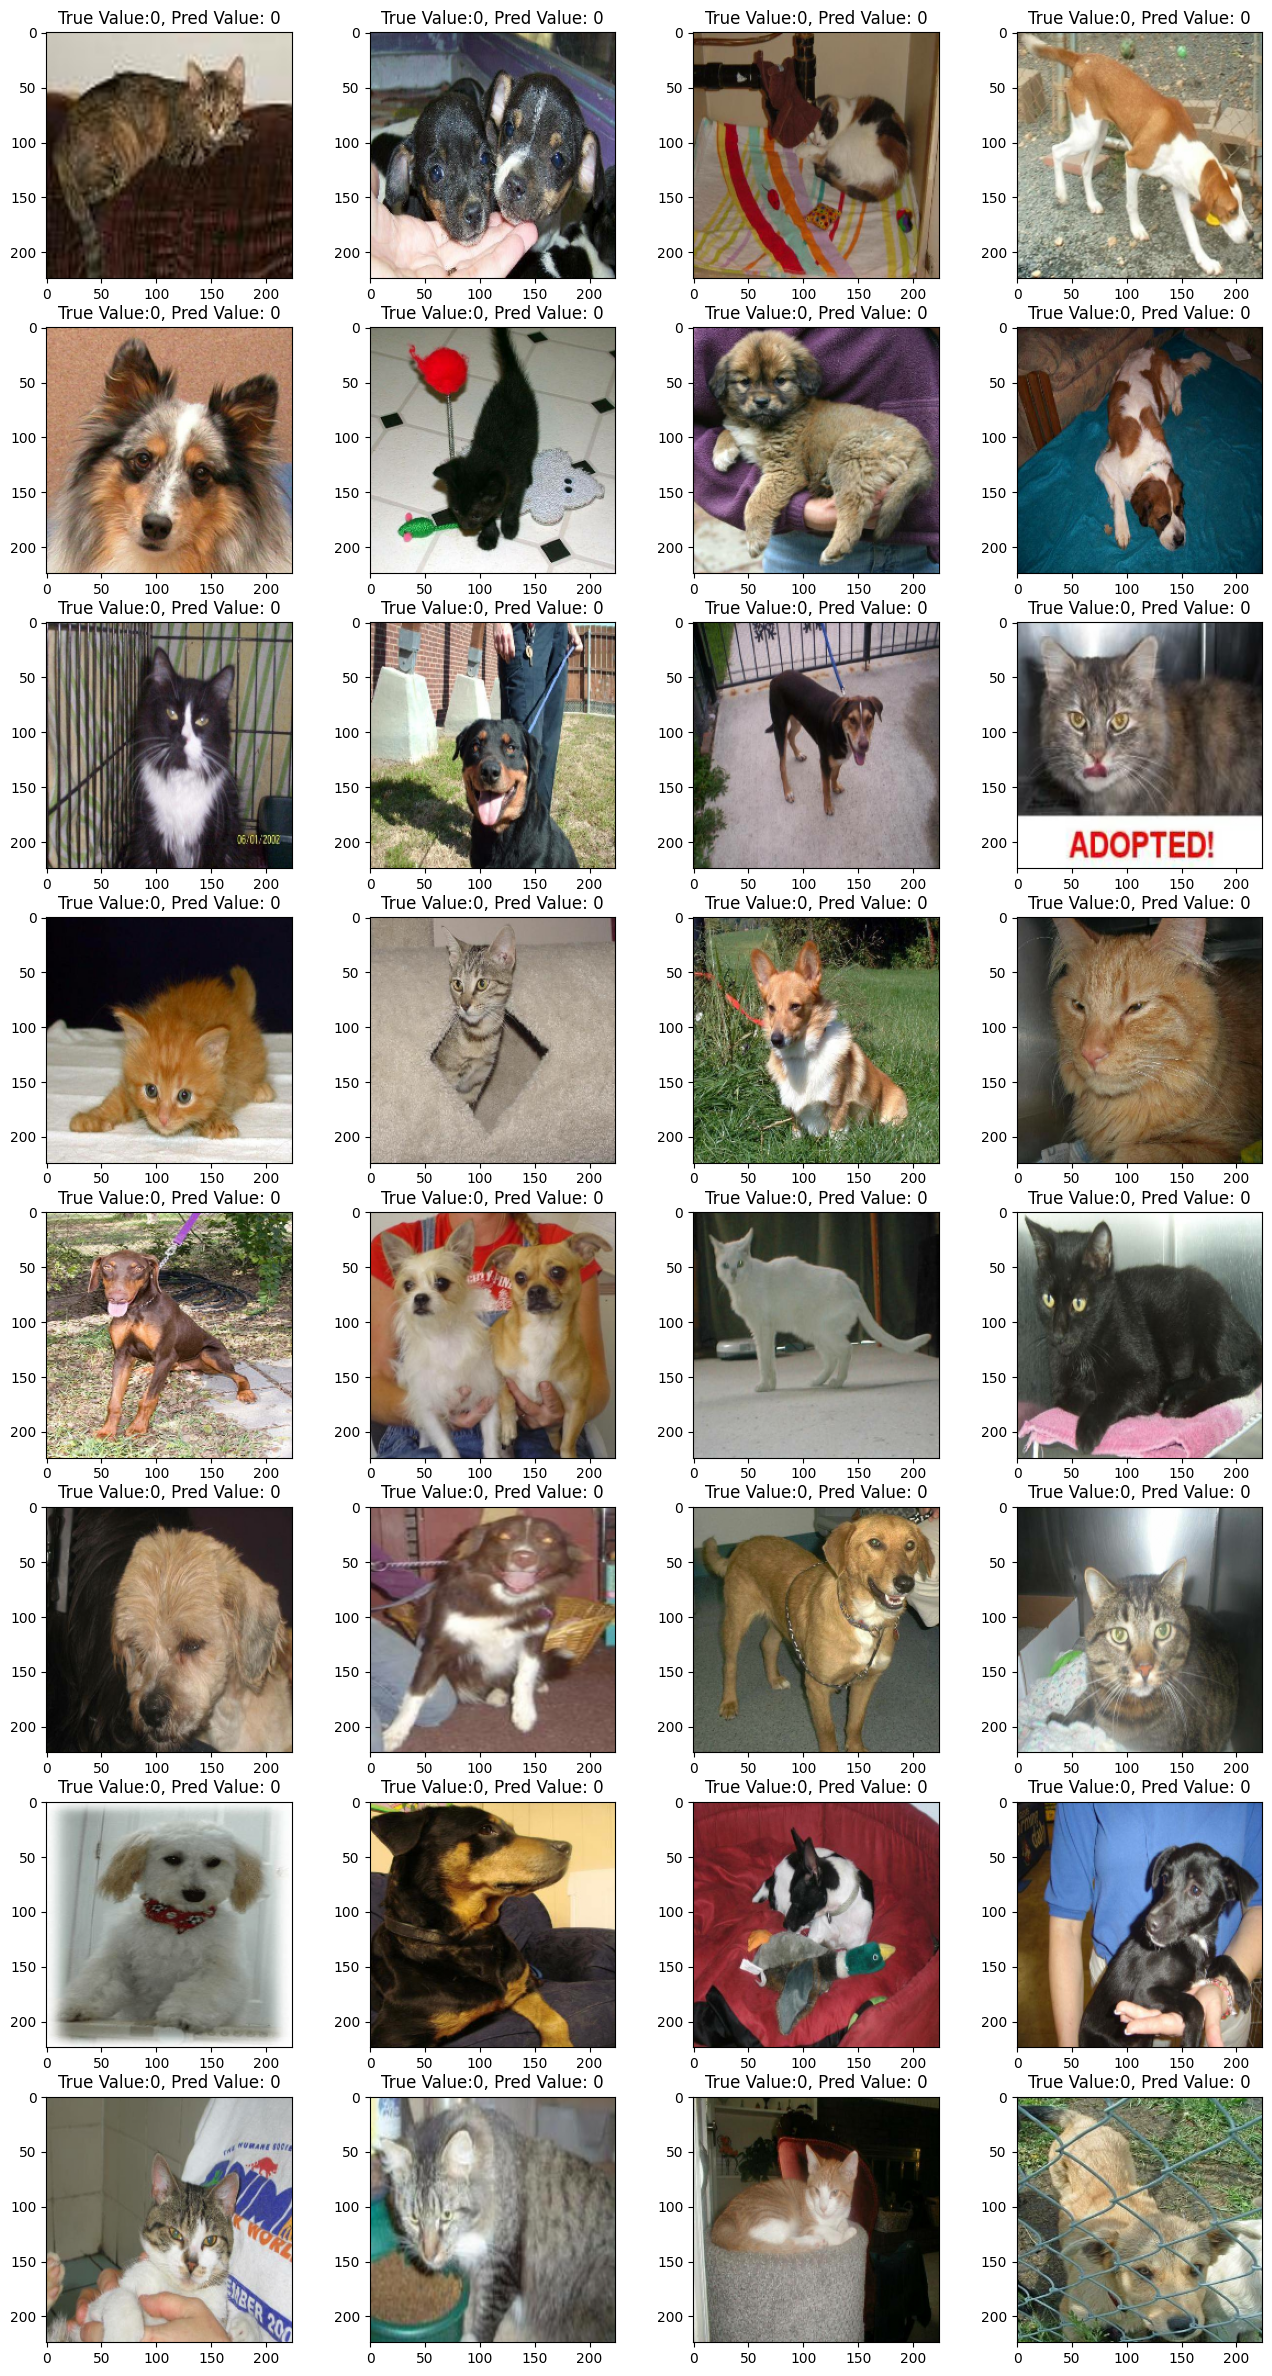

In [78]:
# 100% 성능 보여줌

i = 1
plt.figure(figsize=(16, 30))
for img, label in list(zip(batch_img, batch_label)):
    pred = model.predict(img.numpy().reshape(-1, 224,224,3), verbose=0)
    pred_t = np.argmax(pred)
    plt.subplot(8, 4, i)
    plt.title(f'True Value:{np.argmax(label)}, Pred Value: {pred_t}')
    plt.imshow(img/255)  # 이미지 픽셀값들이 실수형이므로 0~1 사이로 변경해야 에러 안남
    i = i + 1

In [79]:
from keras.preprocessing import image

In [80]:
def predict_images_in_directory(model, folder_path, img_width, img_height):
    results = []
    images = []
    filenames = []

    # 디렉토리 내의 모든 이미지 파일 로드
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        # 이미지 로드 및 전처리
        img = image.load_img(img_path)
        img = img.numpy().reshape(-1, 224,224,3)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        images.append(img_array)
        filenames.append(filename)

    # 배치 처리를 위해 이미지 스택 생성
    images = np.vstack(images)

    # 예측 수행
    predictions = model.predict(images)

    # 결과 저장
    for filename, pred in zip(filenames, predictions):
        results.append([filename, pred])

    return results

In [ ]:
#!ls -al /root/.keras/datasets/flower_photos/
!ls -al /root/.keras/datasets/flower_photos/

total 624
drwxr-x--- 7 270850 5000   4096 Feb 10  2016 .
drwxr-xr-x 3 root   root   4096 Oct 30 13:06 ..
drwx------ 2 270850 5000  36864 Feb 10  2016 daisy
drwx------ 2 270850 5000  45056 Feb 10  2016 dandelion
-rw-r----- 1 270850 5000 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  36864 Feb 10  2016 roses
drwx------ 2 270850 5000  36864 Feb 10  2016 sunflowers
drwx------ 2 270850 5000  49152 Feb 10  2016 tulips


In [83]:
def predict_images_in_directory(model, img_path, batch_size=32):
    class_names = train_ds.class_names
    print("클래스 매핑:", dict(enumerate(class_names)))

    image_files = []
    image_arrays = []

    # 이미지 수집 및 전처리
    for filename in os.listdir(img_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_file_path = os.path.join(img_path, filename)

            # 이미지 로드 및 전처리
            img = tf.keras.preprocessing.image.load_img(
                img_file_path,
                target_size=(224, 224)
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            image_files.append(filename)
            image_arrays.append(img_array)

    # 배치 처리를 위해 numpy 배열로 변환
    image_arrays = np.array(image_arrays)

    # 한 번에 예측 수행
    predictions = model.predict(image_arrays, batch_size=batch_size, verbose=1)
    predicted_classes = [class_names[np.argmax(pred)] for pred in predictions]

    # 결과 생성
    results = list(zip(image_files, predicted_classes))

    return results

# 사용 예시
test_dir = os.path.join(validation_dir, 'cats')
results = predict_images_in_directory(model, test_dir)
print(results.count(1))
# 결과 출력 (처음 5개만)
for filename, type in results:
    print(f"파일명: {filename}, 종류: {type}")

클래스 매핑: {0: 'cats', 1: 'dogs'}
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step
0
파일명: cat.2240.jpg, 종류: cats
파일명: cat.2173.jpg, 종류: cats
파일명: cat.2461.jpg, 종류: cats
파일명: cat.2150.jpg, 종류: cats
파일명: cat.2137.jpg, 종류: cats
파일명: cat.2256.jpg, 종류: cats
파일명: cat.2071.jpg, 종류: cats
파일명: cat.2212.jpg, 종류: cats
파일명: cat.2020.jpg, 종류: cats
파일명: cat.2417.jpg, 종류: cats
파일명: cat.2379.jpg, 종류: cats
파일명: cat.2149.jpg, 종류: cats
파일명: cat.2099.jpg, 종류: cats
파일명: cat.2372.jpg, 종류: cats
파일명: cat.2362.jpg, 종류: cats
파일명: cat.2223.jpg, 종류: cats
파일명: cat.2282.jpg, 종류: cats
파일명: cat.2129.jpg, 종류: cats
파일명: cat.2284.jpg, 종류: cats
파일명: cat.2214.jpg, 종류: cats
파일명: cat.2311.jpg, 종류: cats
파일명: cat.2419.jpg, 종류: cats
파일명: cat.2474.jpg, 종류: cats
파일명: cat.2245.jpg, 종류: cats
파일명: cat.2209.jpg, 종류: cats
파일명: cat.2081.jpg, 종류: cats
파일명: cat.2222.jpg, 종류: cats
파일명: cat.2409.jpg, 종류: cats
파일명: cat.2307.jpg, 종류: cats
파일명: cat.2139.jpg, 종류: cats
파일명: cat.2096.jpg, 종류: cats
파일명: cat.2356.jpg, 종류: cats
파일명: cat.2255.jpg, 종류: cats
파일

In [87]:
import pandas as pd
# DataFrame 생성
df = pd.DataFrame(results, columns=['filename', 'predicted_type'])

csv_filename = f'flower_predictions.csv'

# CSV 파일로 저장
df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"결과가 {csv_filename}에 저장되었습니다.")

# 저장된 결과 확인
print("\n저장된 데이터 미리보기:")
print(df.head())

# 꽃 종류별 개수 확인
print("\n예측 종류별 개수:")
print(df['predicted_type'].value_counts())

결과가 flower_predictions.csv에 저장되었습니다.

저장된 데이터 미리보기:
       filename predicted_type
0  cat.2240.jpg           cats
1  cat.2173.jpg           cats
2  cat.2461.jpg           cats
3  cat.2150.jpg           cats
4  cat.2137.jpg           cats

예측 종류별 개수:
predicted_type
cats    500
Name: count, dtype: int64


## 배운 내용 정리
1. Transfer Learning을 사용하는 방법을 배웠으며 이를 통해 성능을 올릴수 있었습니다.
2. 여러분도 Transfer Learning을 사용하는 방법을 숙지해서 이용할수 있으면 좋겠네요.